In [1]:
import time
from coffea import hist, nanoevents, util
import coffea.processor as processor
import uproot3
import awkward as ak
import numpy as np
import glob as glob
import itertools
from coffea.nanoevents.methods import vector, candidate
from coffea.nanoevents import NanoAODSchema, BaseSchema
import coffea.hist as hist

from calcOffset import *

In [2]:
ak.behavior.update(candidate.behavior)
ak.behavior.update(vector.behavior)

In [3]:
etabins=np.array([-5.191, -4.889, -4.716, -4.538, -4.363, -4.191, -4.013, -3.839, -3.664, -3.489, -3.314, -3.139, -2.964,
         -2.853, -2.65, -2.5, -2.322, -2.172, -2.043, -1.93, -1.83, -1.74, -1.653, -1.566, -1.479, -1.392, -1.305,
         -1.218, -1.131, -1.044, -0.957, -0.879, -0.783, -0.696, -0.609, -0.522, -0.435, -0.348, -0.261, -0.174,
         -0.087, 0, 0.087, 0.174, 0.261, 0.348, 0.435, 0.522, 0.609, 0.696, 0.783, 0.879, 0.957, 1.044, 1.131,
         1.218, 1.305, 1.392, 1.479,1.566, 1.653, 1.74, 1.83, 1.93, 2.043, 2.172, 2.322, 2.5, 2.65, 2.853, 2.964,
         3.139, 3.314, 3.489, 3.664, 3.839, 4.013, 4.191, 4.363, 4.538, 4.716, 4.889, 5.191])
nEta = 82
etaC=0.5*(etabins[:-1]+etabins[1:])

In [4]:
class Histomaker(processor.ProcessorABC):
    def __init__(self, weights=[]):
        self.R = 0.4
        self.mucut = 0
        self._weights = weights
        self.MAXNPV = 100
        self.MAXNPU = 100
        self.MAXRHO = 100
        self.nEta = 82
        self.etabins = np.array([-5.191, -4.889, -4.716, -4.538, -4.363, -4.191, -4.013, -3.839, -3.664,-3.489, -3.314, -3.139, -2.964,
                                 -2.853, -2.65, -2.5, -2.322, -2.172, -2.043, -1.93, -1.83, -1.74, -1.653, -1.566, -1.479, -1.392, -1.305,
                                 -1.218, -1.131, -1.044, -0.957, -0.879, -0.783, -0.696, -0.609, -0.522, -0.435, -0.348, -0.261, -0.174,
                                 -0.087, 0, 0.087, 0.174, 0.261, 0.348,0.435, 0.522, 0.609, 0.696, 0.783, 0.879, 0.957, 1.044, 1.131,1.218,
                                 1.305, 1.392, 1.479,1.566, 1.653, 1.74, 1.83, 1.93, 2.043, 2.172,2.322, 2.5, 2.65, 2.853, 2.964, 3.139,
                                 3.314, 3.489, 3.664, 3.839, 4.013, 4.191, 4.363, 4.538, 4.716, 4.889, 5.191])
        dataset_axis = hist.Cat("dataset", "Dataset")
        flavor_axis = hist.Cat("flavor", "PF Flavor")
        nPU_axis = hist.Bin("nPU", "mu", 2*self.MAXNPU, 0, self.MAXNPU)
        nPV_axis = hist.Bin("nPV", "nPV", 2*self.MAXNPV, 0, self.MAXNPV)
        rho_axis = hist.Bin("rho", "rho", 2*self.MAXRHO, 0, self.MAXRHO)
        eta_axis = hist.Bin("eta", "eta", self.etabins) 
        
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "nPU": hist.Hist("Events", dataset_axis, nPU_axis ),
            "nPV": hist.Hist("Events", dataset_axis, nPV_axis),
            "rho": hist.Hist("Events", dataset_axis, rho_axis),
            
            "p_nPV_nPU": hist.Hist("Events", dataset_axis, nPU_axis ),
            "p_rho_nPU": hist.Hist("Events", dataset_axis, nPU_axis ),
            
            "p_offsetpT_geo_eta_nPU_flavor": hist.Hist("Events", dataset_axis, flavor_axis, nPU_axis,  eta_axis),
            "h_offsetpT_eta_nPU_flavor": hist.Hist("Events", dataset_axis, flavor_axis, nPU_axis,  eta_axis),
            "p_offsetpT_eta_nPU_flavor": hist.Hist("Events", dataset_axis, flavor_axis, nPU_axis,  eta_axis),
            
            # Column accumulators for using hist package
            'PUweight': processor.dict_accumulator({
                "Data": processor.column_accumulator(np.zeros(shape=(0))),
                "MC": processor.column_accumulator(np.zeros(shape=(0))),
            }),
            'nPU_c': processor.dict_accumulator({
                "Data": processor.column_accumulator(np.zeros(shape=(0))),
                "MC": processor.column_accumulator(np.zeros(shape=(0))),
            }),
            'nPV_c': processor.dict_accumulator({
                "Data": processor.column_accumulator(np.zeros(shape=(0))),
                "MC": processor.column_accumulator(np.zeros(shape=(0))),
            }),
            'rho_c': processor.dict_accumulator({
                "Data": processor.column_accumulator(np.zeros(shape=(0))),
                "MC": processor.column_accumulator(np.zeros(shape=(0))),
            }),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()
        dataset = df.metadata['dataset']
        output["sumw"][dataset] += len(df)

        mu = df['mu']
        rho = df['rho']
        nPV = df['nPV']
        
        weight = np.ones_like(mu)
        if (dataset=='MC'):
            index = np.digitize(ak.to_numpy(mu),np.linspace(0,self.MAXNPU, num=2*self.MAXNPU+1))
            weight = weights[index-1]
            
        output["nPU"].fill(dataset=dataset, nPU=mu, weight=weight)
        output["nPV"].fill(dataset=dataset, nPV=nPV, weight=weight)
        output["rho"].fill(dataset=dataset, rho=rho, weight=weight)
        output["p_nPV_nPU"].fill(dataset=dataset, nPU=mu, weight=weight*nPV)
        output["p_rho_nPU"].fill(dataset=dataset, nPU=mu, weight=weight*rho)
        
        output['PUweight'][dataset] += processor.column_accumulator(ak.to_numpy(weight))
        output['nPU_c'][dataset] += processor.column_accumulator(ak.to_numpy(mu))
        output['nPV_c'][dataset] += processor.column_accumulator(ak.to_numpy(nPV))
        output['rho_c'][dataset] += processor.column_accumulator(ak.to_numpy(rho))

        energy = df['energy']
        ids = ['nh', 'ne','chm', 'chu', 'hfh', 'hfe', 'lep', 'untrk']
        
        ## Calculating RC and geometric offset - output shape is (100,82) for each particle type.
        
        for i in range(len(ids)):
            geo_offset = calcGeometricOffset(self.R, energy, df['f'+ids[i]], mu, self.mucut)
            rc_offset = calcOffsetRC(self.R, energy, df['f'+ids[i]])
            for ieta in range(self.nEta):            
                rc_weight_offset = rc_offset[:,ieta]*weight
                weight_offset = geo_offset[:,ieta]*weight
                output["h_offsetpT_eta_nPU_flavor"].fill(dataset=dataset, flavor=ids[i],
                                                         nPU=mu, eta=etaC[ieta],
                                                         weight = weight)
                output["p_offsetpT_eta_nPU_flavor"].fill(dataset=dataset, flavor=ids[i],
                                                         nPU=mu, eta=etaC[ieta],
                                                         weight=rc_weight_offset)
                output["p_offsetpT_geo_eta_nPU_flavor"].fill(dataset=dataset, flavor=ids[i],
                                                             nPU=mu, eta=etaC[ieta],
                                                             weight=weight_offset)
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [5]:
datafile='Total_Data_UL2017_skimmed.root'
mcfile='Total_MC_UL2017_skimmed.root'

In [6]:
data = uproot3.open(datafile)["T"]
MC = uproot3.open(mcfile)["T"]

weights = getWeights(data, MC)

fileset = {
    'Data': [datafile],
    'MC': [mcfile]
}
tic = time.time()
output = processor.run_uproot_job(
    fileset,
    treename="T",
    processor_instance=Histomaker(weights=weights),
    executor=processor.futures_executor,
    executor_args={'workers':4},
)
elapsed = time.time() - tic
print(f"Output: {output}")
print(f"Finished in {elapsed:.1f}s")

Time:  0.01977062225341797


/srv/calcOffset.py:20: RuntimeWarning: divide by zero encountered in true_divide
  ratio = np.where(h_weights_mc>0, h_weights/h_weights_mc, 0)
/srv/calcOffset.py:20: RuntimeWarning: invalid value encountered in true_divide
  ratio = np.where(h_weights_mc>0, h_weights/h_weights_mc, 0)


Preprocessing:   0%|          | 0/2 [00:00<?, ?file/s]

Processing:   0%|          | 0/2 [00:00<?, ?chunk/s]

/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:89: UserWarning: Skipping mua as it is not interpretable by NanoEvents
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:89: UserWarning: Skipping puz as it is not interpretable by NanoEvents
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:89: UserWarning: Skipping et_gme as it is not interpretable by NanoEvents
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:89: UserWarning: Skipping mua as it is not interpretable by NanoEvents
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:89: UserWarning: Skipping ch_et_gme as it is not interpretable by NanoEvents
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:89: UserWarning: Skipping puz as it is not interpretable by NanoEvents
  warnings.warn(
/opt/conda/li

Output: {'sumw': defaultdict_accumulator(<class 'float'>, {'MC': 40639.0, 'Data': 100620.0}), 'nPU': <Hist (dataset,nPU) instance at 0x7fc6cd64cd90>, 'nPV': <Hist (dataset,nPV) instance at 0x7fc6c40e0be0>, 'rho': <Hist (dataset,rho) instance at 0x7fc6c40e0c10>, 'p_nPV_nPU': <Hist (dataset,nPU) instance at 0x7fc6cd6610d0>, 'p_rho_nPU': <Hist (dataset,nPU) instance at 0x7fc6cd661100>, 'p_offsetpT_geo_eta_nPU_flavor': <Hist (dataset,flavor,nPU,eta) instance at 0x7fc6cd661070>, 'h_offsetpT_eta_nPU_flavor': <Hist (dataset,flavor,nPU,eta) instance at 0x7fc6cd661130>, 'p_offsetpT_eta_nPU_flavor': <Hist (dataset,flavor,nPU,eta) instance at 0x7fc6cd661160>, 'PUweight': {'Data': column_accumulator(array([1., 1., 1., ..., 1., 1., 1.])), 'MC': column_accumulator(array([0.05322339, 0.0557971 , 0.06266334, ..., 0.0612567 , 0.06581401,
       0.05419983]))}, 'nPU_c': {'Data': column_accumulator(array([25.51611519, 32.88453293, 32.88453293, ..., 26.30153656,
       26.27523994, 26.25378799])), 'MC': c

# Plotting histograms, profiles using coffea.hist

In [7]:
from matplotlib import gridspec
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)
plt.rc('font', family='serif', size=13)
from plotting import *

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-fyi6f4q5 because the default path (/uscms/home/gagarwal/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [8]:
plt.rcParams['figure.dpi'] = 120

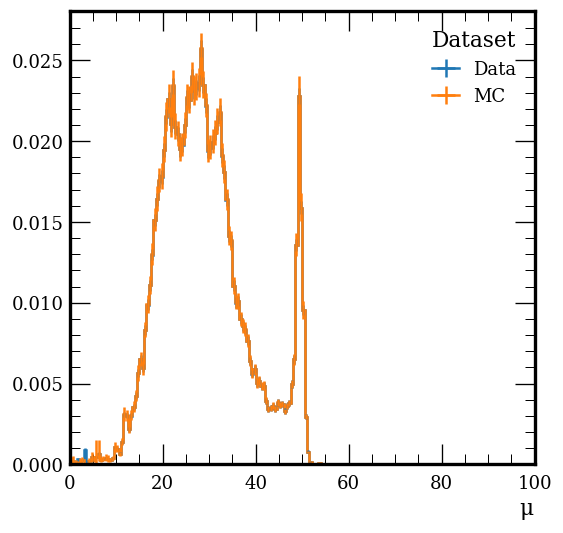

In [9]:
plotHist(output, 'nPU', r'$\mu$')
# plotHist(output, 'nPV', r'$n_{PV}$')
# plotHist(output, 'rho', r'$\rho$')

In [10]:
def plotProfile(output, x_var, hist_2d, xlow, xhigh, xlabel, ylabel):
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(5,5),
        gridspec_kw={"height_ratios": (3, 1)},
        sharex=True
    )
    fig.subplots_adjust(hspace=.07)
    num1 = output[hist_2d].integrate('dataset','Data') 
    denom1 = output[x_var].integrate('dataset','Data') 
    hist.plotratio(num1, denom1, unc='num', ax=ax,
                   error_opts={'marker':'o', 'markersize': 3.,
                               'markeredgecolor':'k', 'color':'k',
                               'elinewidth': 0.5, },label='Data', clear=False,)
    num2 = output[hist_2d].integrate('dataset','MC') 
    denom2 = output[x_var].integrate('dataset','MC') 
    hist.plotratio(num2, denom2, unc='num',ax=ax,
                   error_opts={'marker':'o', 'markersize': 3.,
                               'markeredgecolor':'r', 'color':'none',
                               'elinewidth': 1.0, },label='MC',clear=False)
    ax.set_xlim(xlow, xhigh)
    ax.set_ylim(0, 60)
    rax.set_ylim(0.7, 1.3)
    ax.set_xlabel(None)
    rax.set_xlabel(xlabel)
    rax.set_ylabel('Data/MC')
    ax.set_ylabel(ylabel)
    ax.grid(color='b', ls = '-.', lw = 0.25)
    ax.legend()
    nbins = len(output[x_var].values()['Data',])
    bin_center = 0.5*(np.linspace(0,nbins/2,nbins+1)[:-1]+np.linspace(0,nbins/2,nbins+1)[1:])
    im = rax.scatter(bin_center,(num1.values()[()]*denom2.values()[()])/(num2.values()[()]*denom1.values()[()]),
                     s=5, marker='o', facecolors='none', edgecolor='k')
    im = rax.plot(bin_center, np.ones(len(bin_center)), '--', color='gray')

/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:423: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:435: RuntimeWarning: invalid value encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom ** 2) - rsumw
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:423: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:435: RuntimeWarning: invalid value encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom ** 2) - rsumw
/tmp/ipykernel_31938/2585670693.py:33: RuntimeWarning: divide by zero encountered in true_divide
  im = rax.scatter(bin_center,(num1.values()[()]*denom2.values()[()])/(num2.values()[()]*denom1.values()[()]),
/tmp/ipykernel_31938/2585670693.py:33: RuntimeWarning: invalid value encountered in true_divide
  im = rax.scatter(bin

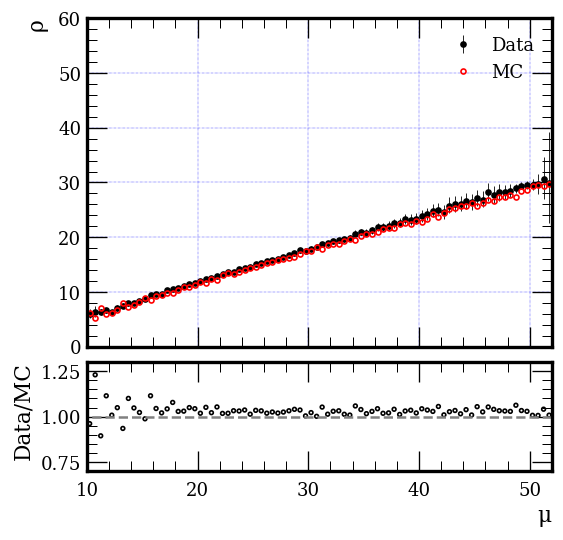

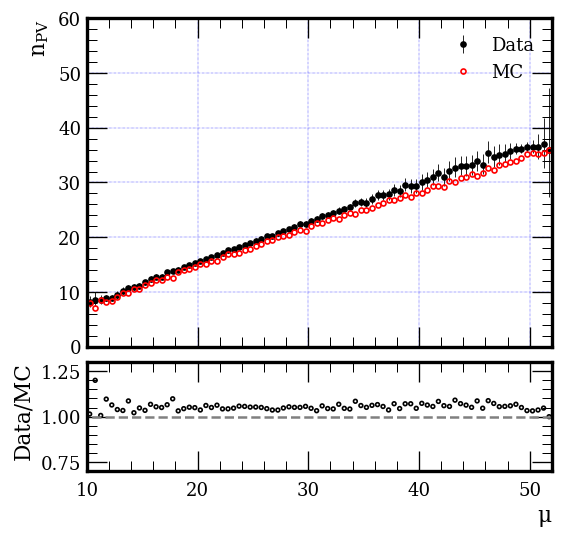

In [11]:
plotProfile(output, 'nPU', 'p_rho_nPU', 10, 52, r'$\mu$', r'$\rho$')
plotProfile(output, 'nPU', 'p_nPV_nPU', 10, 52, r'$\mu$', r'$n_{PV}$')

/srv/plotting.py:303: RuntimeWarning: invalid value encountered in true_divide
  x_data = np.where(denom1.values()[()]>0., num1.values()[()]/denom1.values()[()], 0)
/srv/plotting.py:307: RuntimeWarning: invalid value encountered in true_divide
  x_mc = np.where(denom2.values()[()]>0., num2.values()[()]/denom2.values()[()], 0)
/srv/plotting.py:311: RuntimeWarning: divide by zero encountered in true_divide
  yvals_d = (offset_v_eta_data.values()[()]* (1/norm_data))
/srv/plotting.py:311: RuntimeWarning: invalid value encountered in multiply
  yvals_d = (offset_v_eta_data.values()[()]* (1/norm_data))
/srv/plotting.py:312: RuntimeWarning: divide by zero encountered in true_divide
  yvals_m = (offset_v_eta_mc.values()[()]* (1/norm_mc))
/srv/plotting.py:312: RuntimeWarning: invalid value encountered in multiply
  yvals_m = (offset_v_eta_mc.values()[()]* (1/norm_mc))
/srv/plotting.py:313: RuntimeWarning: divide by zero encountered in true_divide
  yerr_d = (offset_v_eta_data.values(sumw2=True)

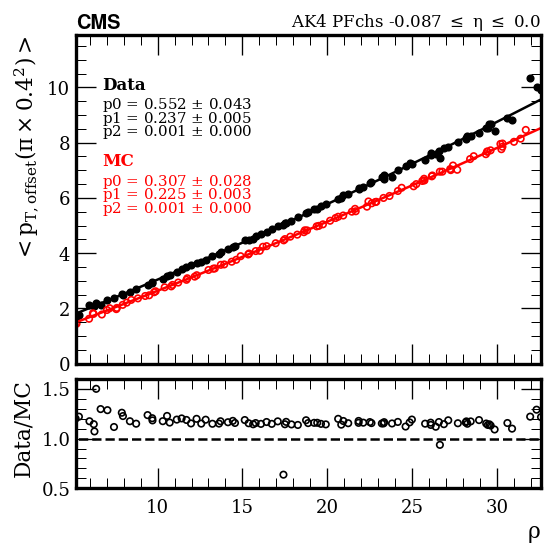

In [13]:
fitProfile(output, 'nPU', 'p_offsetpT_eta_nPU_flavor', 'h_offsetpT_eta_nPU_flavor', 'p_rho_nPU',
           r'$\rho$', r"$<p_{T,offset}(\pi \times 0.4^{2})>$", 40, 10, 52)
# fitProfile(output, 'nPU', 'p_offsetpT_eta_nPU_flavor', 'h_offsetpT_eta_nPU_flavor', 'p_rho_nPU',
#            r'$\rho$', r"$<p_{T,offset}(\pi \times 0.4^{2})>$", 72, 10, 52)
# fitProfile(output, 'nPU', 'p_offsetpT_eta_nPU_flavor', 'h_offsetpT_eta_nPU_flavor', 'p_rho_nPU',
#            r'$\rho$', r"$<p_{T,offset}(\pi \times 0.4^{2})>$", 80, 10, 52)

/srv/plotting.py:61: RuntimeWarning: divide by zero encountered in true_divide
  r_chm = np.where(m_chm>1e-5, d_chm/m_chm, 0)
/srv/plotting.py:61: RuntimeWarning: invalid value encountered in true_divide
  r_chm = np.where(m_chm>1e-5, d_chm/m_chm, 0)
No handles with labels found to put in legend.


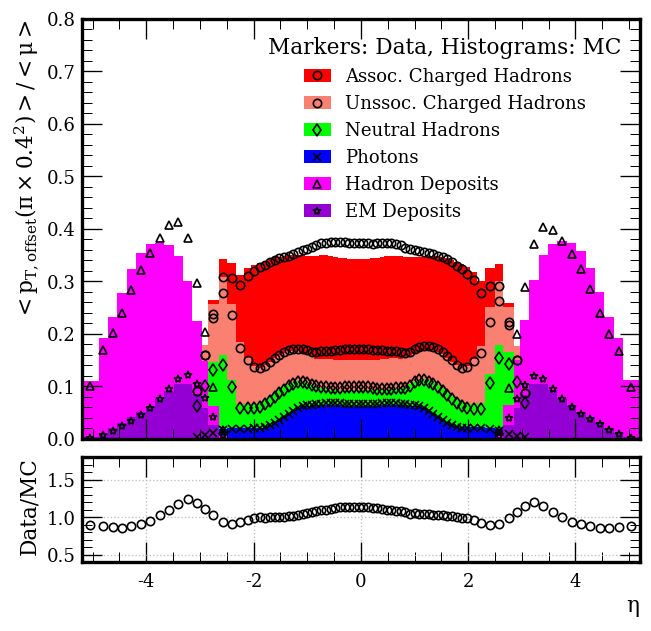

/srv/plotting.py:61: RuntimeWarning: divide by zero encountered in true_divide
  r_chm = np.where(m_chm>1e-5, d_chm/m_chm, 0)
/srv/plotting.py:61: RuntimeWarning: invalid value encountered in true_divide
  r_chm = np.where(m_chm>1e-5, d_chm/m_chm, 0)
/srv/plotting.py:65: RuntimeWarning: invalid value encountered in true_divide
  r_hfh_l = np.where(m_hfh_l>1e-5, d_hfh_l/m_hfh_l, 0)
/srv/plotting.py:66: RuntimeWarning: invalid value encountered in true_divide
  r_hfe_l = np.where(m_hfe_l>1e-5, d_hfe_l/m_hfe_l, 0)
/srv/plotting.py:67: RuntimeWarning: invalid value encountered in true_divide
  r_hfh_r = np.where(m_hfh_r>1e-5, d_hfh_r/m_hfh_r, 0)
/srv/plotting.py:68: RuntimeWarning: invalid value encountered in true_divide
  r_hfe_r = np.where(m_hfe_r>1e-5, d_hfe_r/m_hfe_r, 0)


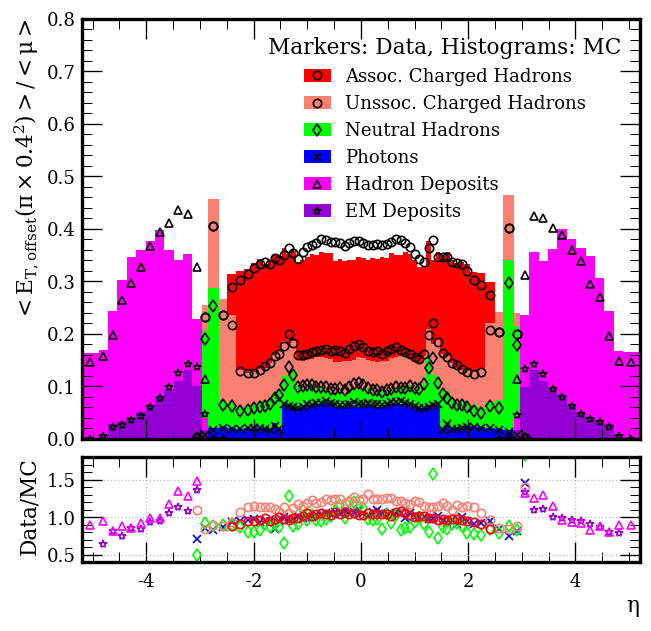

In [14]:
plotStack(output, 'eta', 'p_offsetpT_eta_nPU_flavor', 'nPU', 30, 31, r"$<p_{T,offset}(\pi \times 0.4^{2})> / <\mu>$",'all', 0.8, False)
plotStack(output, 'eta', 'p_offsetpT_geo_eta_nPU_flavor', 'nPU', 30, 31, r"$<E_{T,offset}(\pi \times 0.4^{2})> / <\mu>$",'all', 0.8, True)

/srv/plotting.py:61: RuntimeWarning: divide by zero encountered in true_divide
  r_chm = np.where(m_chm>1e-5, d_chm/m_chm, 0)
/srv/plotting.py:61: RuntimeWarning: invalid value encountered in true_divide
  r_chm = np.where(m_chm>1e-5, d_chm/m_chm, 0)


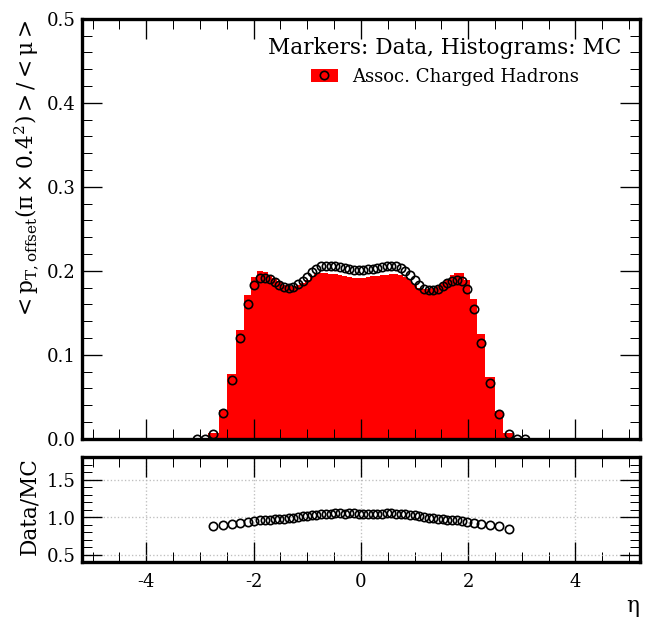

/srv/plotting.py:61: RuntimeWarning: divide by zero encountered in true_divide
  r_chm = np.where(m_chm>1e-5, d_chm/m_chm, 0)
/srv/plotting.py:61: RuntimeWarning: invalid value encountered in true_divide
  r_chm = np.where(m_chm>1e-5, d_chm/m_chm, 0)


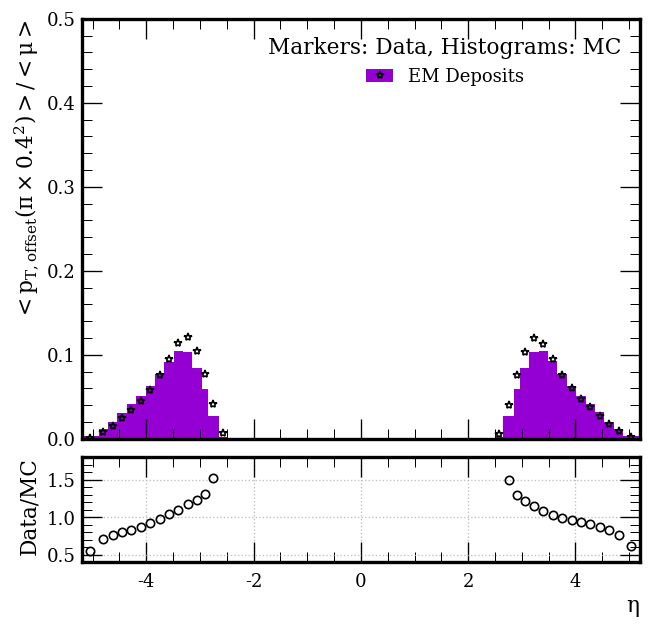

In [15]:
plotStack(output, 'eta', 'p_offsetpT_eta_nPU_flavor', 'nPU', 30, 31, r"$<p_{T,offset}(\pi \times 0.4^{2})> / <\mu>$",'chm', 0.5, True)
plotStack(output, 'eta', 'p_offsetpT_eta_nPU_flavor', 'nPU', 30, 31, r"$<p_{T,offset}(\pi \times 0.4^{2})> / <\mu>$",'hfe', 0.5, True)

/srv/plotting.py:61: RuntimeWarning: divide by zero encountered in true_divide
  r_chm = np.where(m_chm>1e-5, d_chm/m_chm, 0)
/srv/plotting.py:61: RuntimeWarning: invalid value encountered in true_divide
  r_chm = np.where(m_chm>1e-5, d_chm/m_chm, 0)
/srv/plotting.py:65: RuntimeWarning: invalid value encountered in true_divide
  r_hfh_l = np.where(m_hfh_l>1e-5, d_hfh_l/m_hfh_l, 0)
/srv/plotting.py:66: RuntimeWarning: invalid value encountered in true_divide
  r_hfe_l = np.where(m_hfe_l>1e-5, d_hfe_l/m_hfe_l, 0)
/srv/plotting.py:67: RuntimeWarning: invalid value encountered in true_divide
  r_hfh_r = np.where(m_hfh_r>1e-5, d_hfh_r/m_hfh_r, 0)
/srv/plotting.py:68: RuntimeWarning: invalid value encountered in true_divide
  r_hfe_r = np.where(m_hfe_r>1e-5, d_hfe_r/m_hfe_r, 0)


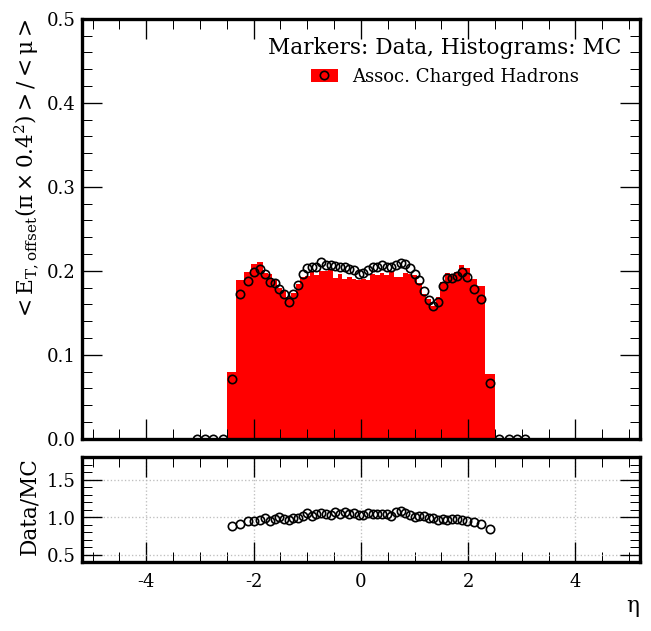

/srv/plotting.py:61: RuntimeWarning: divide by zero encountered in true_divide
  r_chm = np.where(m_chm>1e-5, d_chm/m_chm, 0)
/srv/plotting.py:61: RuntimeWarning: invalid value encountered in true_divide
  r_chm = np.where(m_chm>1e-5, d_chm/m_chm, 0)
/srv/plotting.py:65: RuntimeWarning: invalid value encountered in true_divide
  r_hfh_l = np.where(m_hfh_l>1e-5, d_hfh_l/m_hfh_l, 0)
/srv/plotting.py:66: RuntimeWarning: invalid value encountered in true_divide
  r_hfe_l = np.where(m_hfe_l>1e-5, d_hfe_l/m_hfe_l, 0)
/srv/plotting.py:67: RuntimeWarning: invalid value encountered in true_divide
  r_hfh_r = np.where(m_hfh_r>1e-5, d_hfh_r/m_hfh_r, 0)
/srv/plotting.py:68: RuntimeWarning: invalid value encountered in true_divide
  r_hfe_r = np.where(m_hfe_r>1e-5, d_hfe_r/m_hfe_r, 0)


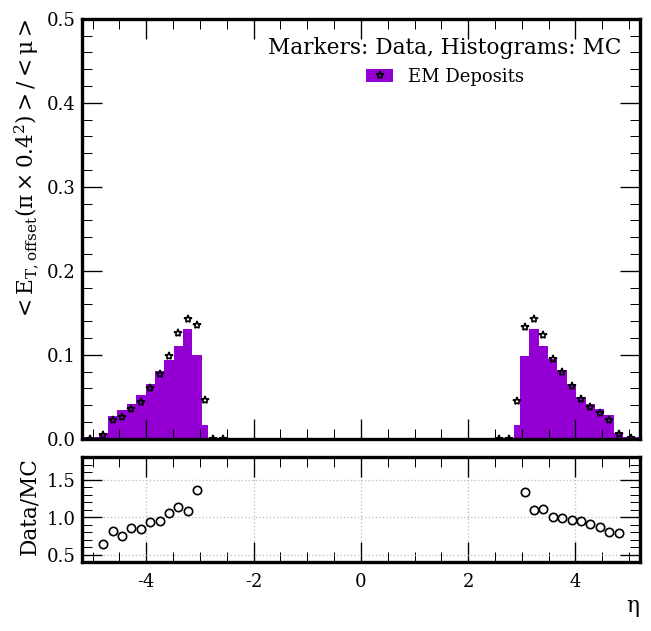

In [16]:
plotStack(output, 'eta', 'p_offsetpT_geo_eta_nPU_flavor', 'nPU', 30, 31, r"$<E_{T,offset}(\pi \times 0.4^{2})> / <\mu>$",'chm', 0.5, True)
plotStack(output, 'eta', 'p_offsetpT_geo_eta_nPU_flavor', 'nPU', 30, 31, r"$<E_{T,offset}(\pi \times 0.4^{2})> / <\mu>$",'hfe', 0.5, True)

# Using hist package for plotting

In [17]:
import hist as histo
from hist import Hist

In [18]:
nPU_axis = histo.axis.Regular(bins=200, start=0, stop=100, name="mu", label=r'$\mu$')
nPV_axis = histo.axis.Regular(bins=200, start=0, stop=100, name="npv", label='nPV')
rho_axis = histo.axis.Regular(bins=200, start=0, stop=100, name="rho", label=r'$\rho$')
dataset_axis = histo.axis.StrCategory(["Data", "MC"], name="dataset")

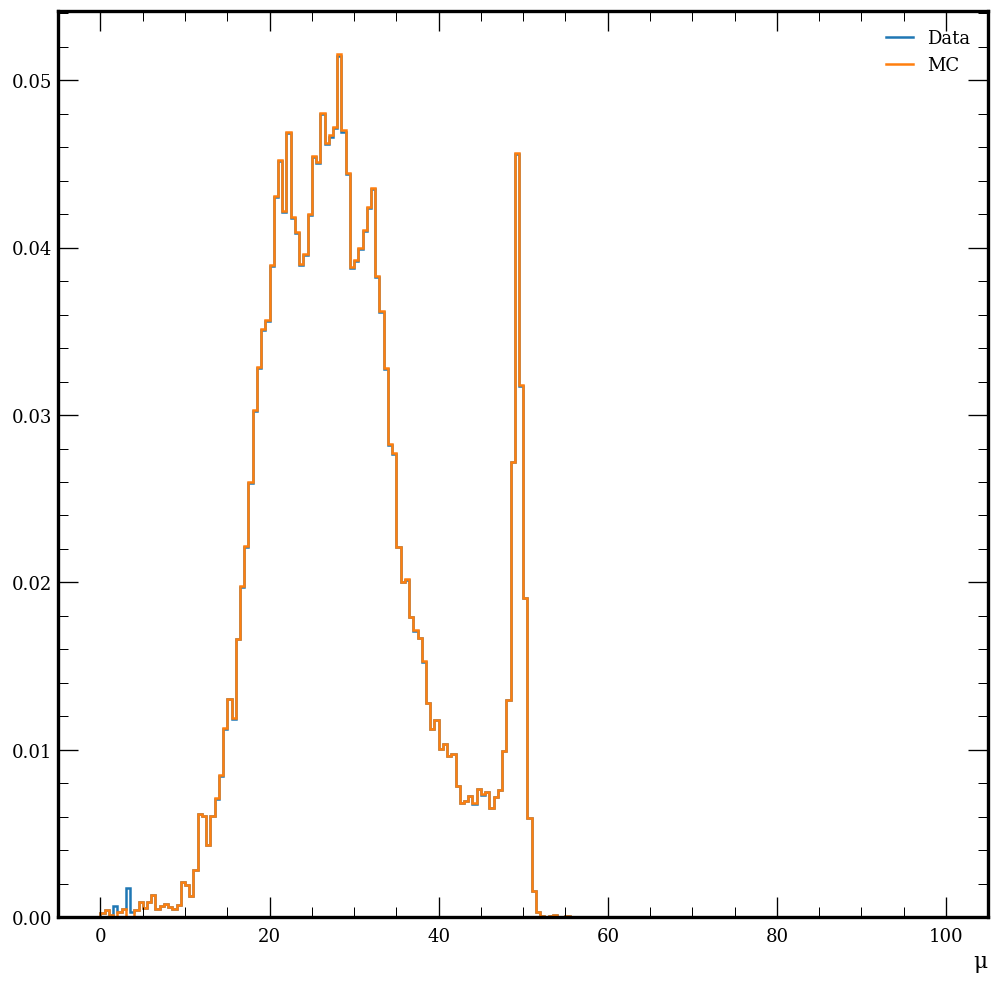

In [19]:
hist1 = Hist(nPU_axis, dataset_axis)
hist1.fill(mu=output['nPU_c']['Data'].value, dataset="Data", weight=output['PUweight']['Data'].value)
hist1.fill(mu=output['nPU_c']['MC'].value, dataset="MC", weight = output['PUweight']['MC'].value)
hist1.plot1d(density=True)
plt.legend()

In [20]:
# hist1 = Hist(nPV_axis, dataset_axis)
# hist1.fill(npv=output['nPV_c']['Data'].value, dataset="Data", weight=output['PUweight']['Data'].value)
# hist1.fill(npv=output['nPV_c']['MC'].value, dataset="MC", weight = output['PUweight']['MC'].value)
# hist1.plot1d(density=True)
# plt.legend()

In [21]:
# hist1 = Hist(rho_axis, dataset_axis)
# hist1.fill(rho=output['rho_c']['Data'].value, dataset="Data", weight=output['PUweight']['Data'].value)
# hist1.fill(rho=output['rho_c']['MC'].value, dataset="MC", weight = output['PUweight']['MC'].value)
# hist1.plot1d(density=True)
# plt.legend()

In [22]:
hist3 = Hist(nPU_axis, nPV_axis, dataset_axis)
hist3.fill(mu=output['nPU_c']['Data'].value, npv=output['nPV_c']['Data'].value, dataset="Data", weight=output['PUweight']['Data'].value)
hist3.fill(mu=output['nPU_c']['MC'].value, npv=output['nPV_c']['MC'].value, dataset="MC", weight=output['PUweight']['MC'].value)
hp3 = hist3.profile("npv")

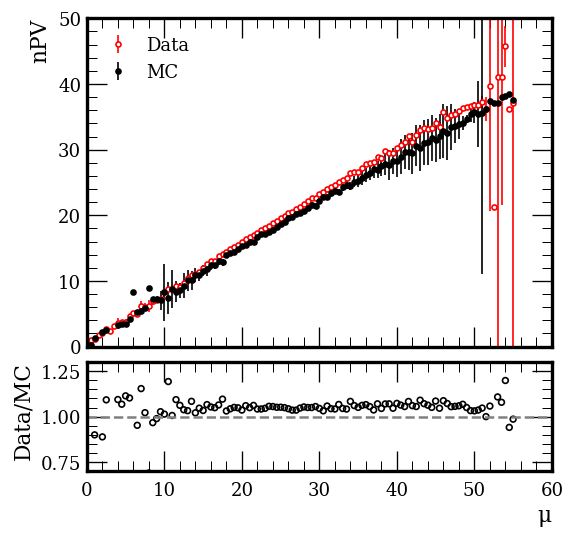

In [23]:
fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(5,5),
        gridspec_kw={"height_ratios": (3, 1)},
        sharex=True
    )
fig.subplots_adjust(hspace=.07)
x = np.arange(0,100,0.5)
ax.errorbar(x, hp3.view().value[:,0], yerr=hp3.variances()[:,0], label='Data', fmt='.', mec='red', ecolor='red',color='white', lw=1)
ax.errorbar(x, hp3.view().value[:,1], yerr=hp3.variances()[:,1], label='MC', fmt='.', mec='k', color='k', lw=1)
rax.scatter(x, (hp3.view().value[:,0])/(hp3.view().value[:,1]), marker='o', facecolors='none', edgecolors='k', s=12)
rax.plot(x, np.ones_like(x), linestyle='--', color='gray');
rax.set_ylim(0.7, 1.3)
rax.set_xlim(0, 60)
ax.set_ylim(0, 50)
ax.set_xlim(0, 60)
ax.set_xlabel(None)
ax.set_ylabel('nPV')
rax.set_xlabel(r'$\mu$')
rax.set_ylabel('Data/MC')
ax.legend(loc='upper left')
plt.show()